### Class 03 - Example

In this notebook, we will build on what we did last week and explore the potential of regularization.

Today's tasks are the following:
1. Go back to your data and consider whether any data transformations (e.g., standardization) is needed. If so, take a look at available preprocessing extractors: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. `StandardScaler` and `MinMaxScaler` are the ones you want to consider;
2. Apply L1 and L2 regularization to your models, using `Lasso` and `Ridge` estimators from sklearn. You'll want to select a reasonable regularization parameter `alpha`;
3. Visualize the impact of regularization on performance and predictors.

Let's get started!

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler


First, let's load our dataset. Here, I will reload a dataset to make the example complete, but you can import your training, development and test sets from the last exercise.

In [164]:
data = datasets.load_diabetes(as_frame=True)['data']
data['target'] = datasets.load_diabetes(as_frame=True)['target']
X = data.iloc[:,:10].values
y = data.iloc[:,10].values

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

This time, let's also standardize the data, which we will need for regularization.
Note that I am fitting the standardizer to the training set, and applying the same transformation to validation and test set.
Can you guess why I am doing that?

In [166]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Model estimation
Let's re-estimate our baseline models. This time, we wrap model evaluation into a function, to make our code compact.

In [182]:
performances = []

In [183]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

First, let's recompute the dummy model

In [184]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=None, 
             X=x, y=y, 
             nsplit=nsplit, 
             model_name='dummy', 
             constant_value=y_train.mean())

Now let's fit a linear model with only demographic predictors

In [185]:
dem_cols = range(4)
reg = LinearRegression().fit(X_train[:,dem_cols], y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                      [y_train, y_val, y_test],
                      ['train', 'val', 'test']):
    evaluate(model=reg, 
             X=x[:,dem_cols], y=y, 
             nsplit=nsplit, 
             model_name='linear-model-dem')

### Full model
Finally, let's add all our predictors. First, let's fit a regular linear model, and evaluate its performance on all splits.
To make things more interesting, you can also add Polynomial models here (see previous week's notebook)

In [186]:
reg = LinearRegression().fit(X_train, y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=reg, 
                X=x, y=y, 
                nsplit=nsplit, 
                model_name=f'linear-full')

In [187]:
perf_df = pd.DataFrame(performances)

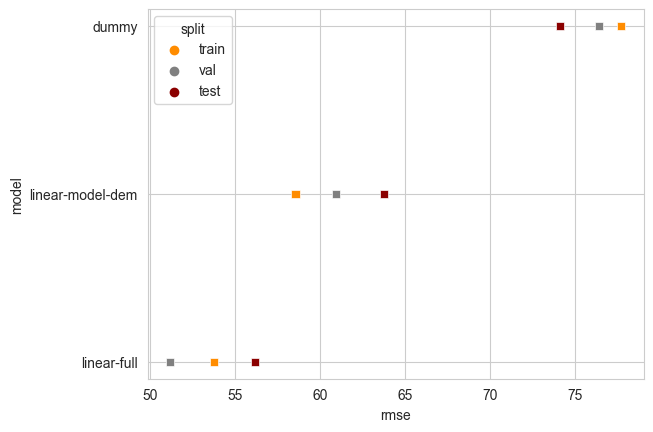

In [188]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

Alright, our best model is still the linear model. In our case there is not a whole lot of overfitting, but let's try to reduce the little there is nonetheless.
As we have discussed in the lecture, one way to do it is to apply regularization. We don't have any strong prior 
for whether L1 or L2 would be most appropriate in our case. Let's implement both!

For Ridge, we will use this estimator: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

For LASSO, we will use this estimator: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

We will need to tune our regulariation parameter, let's first do it manually, and we can then look at one way to do this automatically.

Let's also store the models to check what happens as we increase the parameter values!

In [189]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

In [190]:
for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train, X_val, X_test],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

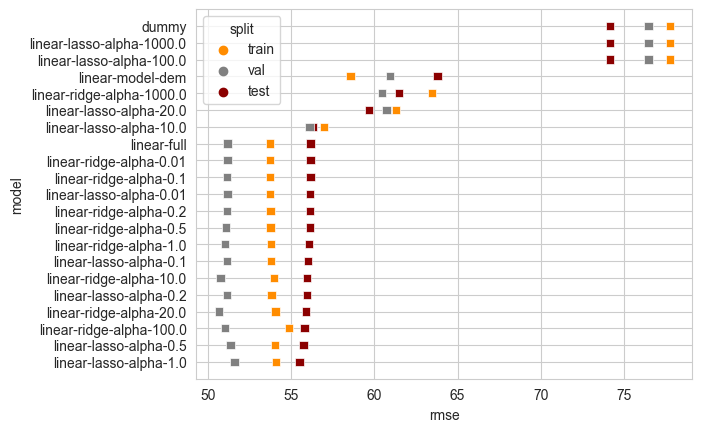

In [191]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

As you can see, our test set has a slightly lower error once the regularization is added.
Let's visualize what happens to the coefficients, in both the L1 and L2 scenario, once the amount of regularization we add increases. Let's extract coefficients, store them into a dataframe, and plot them.

In [197]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=data.iloc[:,:10].columns)
coefs['mtype'] = [k.split('-')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('-')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

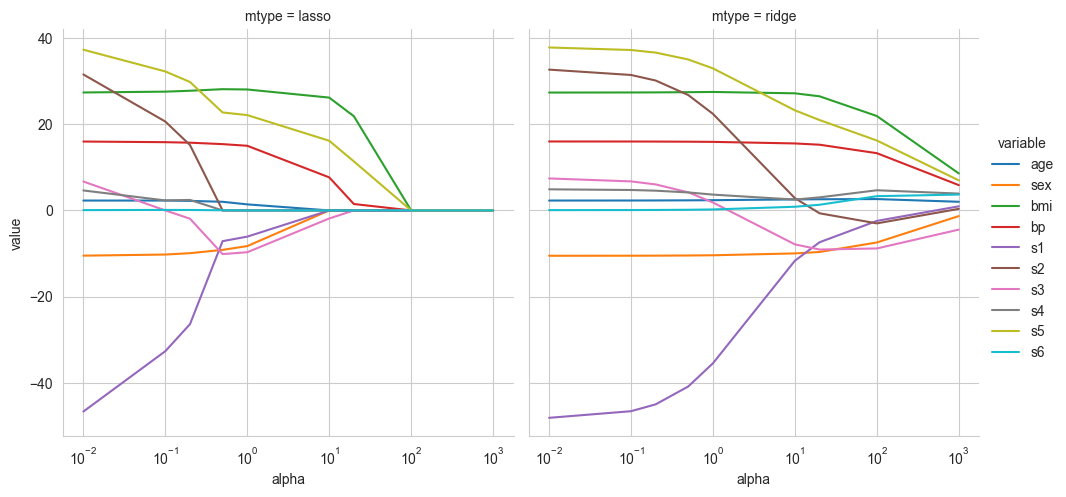

In [198]:
grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")

As you can see, what we know about the effect of L1 and L2 loss is very visible here. Also note that the way coefficients are shrunk over alphas is fairly consistent, i.e., as alpha increases, coefficients monotonically go down or up. Now, let's visualize the weights of the non-regularized linear regression versus the weights of the best LASSO and the best Ridge model that outperform the linear model.

In [207]:
perf_df[perf_df['split']=='test'].sort_values(by='rmse', ascending=True)

,model,split,rmse,r2
35,linear-lasso-alpha-1.0,test,55.5073,0.4360
29,linear-lasso-alpha-0.5,test,55.7557,0.4309
56,linear-ridge-alpha-100.0,test,55.8093,0.4298
44,linear-ridge-alpha-20.0,test,55.8914,0.4282
23,linear-lasso-alpha-0.2,test,55.9471,0.4270
50,linear-ridge-alpha-10.0,test,55.9586,0.4268
17,linear-lasso-alpha-0.1,test,56.0059,0.4258
38,linear-ridge-alpha-1.0,test,56.0856,0.4242
32,linear-ridge-alpha-0.5,test,56.1190,0.4235
26,linear-ridge-alpha-0.2,test,56.1481,0.4229


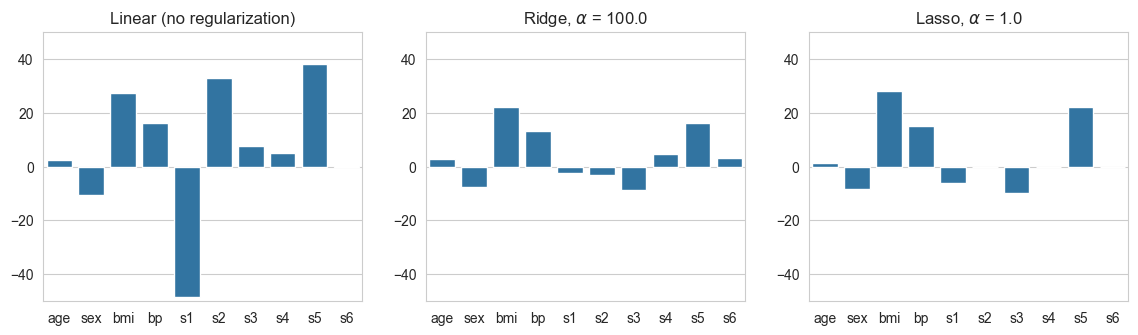

In [208]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3.5))
sns.barplot(x=data.iloc[:,:10].columns, y=models['lasso-1.0'].coef_, ax=ax[2], color=sns.color_palette()[0])
sns.barplot(x=data.iloc[:,:10].columns, y=models['ridge-100.0'].coef_, ax=ax[1], color=sns.color_palette()[0])
sns.barplot(x=data.iloc[:,:10].columns, y=models['linear-0.0'].coef_, ax=ax[0], color=sns.color_palette()[0])
for a in ax:
    a.set_ylim(-50,50)
ax[2].set_title('Lasso, $\\alpha$ = 1.0')
ax[1].set_title('Ridge, $\\alpha$ = 100.0')
ax[0].set_title('Linear (no regularization)')
plt.show()

A few things to note here:
1. Coefficients are consistenly smaller when regularization is added;
2. The sign and relative magnitude of coefficients is fairly similar across LASSO and Ridge
3. The most two most notable effects are:
    - A large reduction in the size of coefficietns for s1 and s2
    - A change in directionality for the effect of s3

If we look back at the correlation matrix for our data we will see why this happens: shrinkage or feature has a pretty strong effect in the presence of collinearity.
While previously collineary features (`sex` and `s3`, and `s1` and `s2`) were estimated to have large but opposite coefficients, Ridge and Lasso estimate smaller and more consistent coefficients, which reduce model variance and the extent to which overfitting happens.

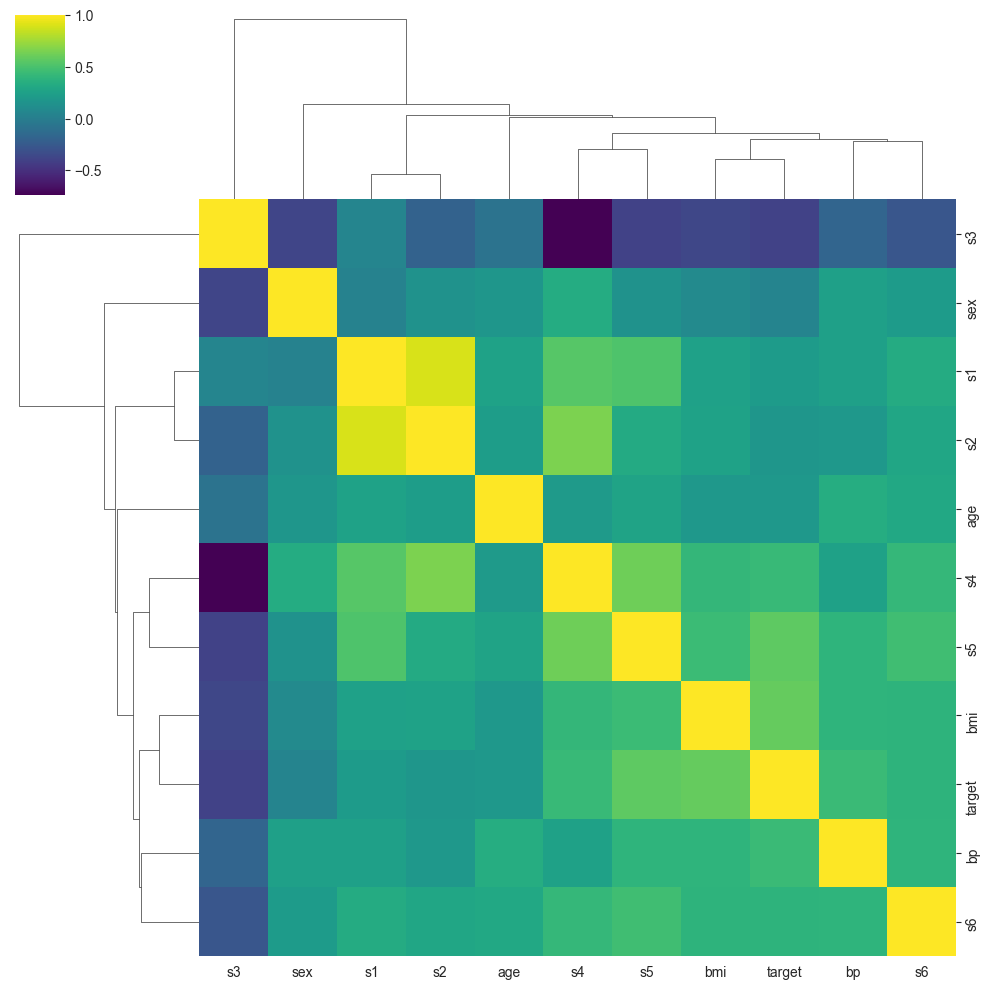

In [209]:
sns.clustermap(data.corr(), cmap='viridis')

A couple of final notes: while we have only estimated Ridge and LASSO for linear models, L1 and L2 regularization can be applied to virtually any model.
As we will see next week, `RandomForest` models, for example, have an alpha parameter that represents the amount of regularization added to the loss.
Finally, while (for pedagogical reasons) we have looked at the effect of a wide range of alphas, you can use `RidgeCV` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) or `LassoCV` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) from sklearn to select the best alpha using cross-validation on the training set.

Next week, we will also look at `GridSearchCV` as a general way to select model hyperparameters.